In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings("ignore")
np.random.seed(1569)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

In [3]:
rho = 0.6
N = 500000
NumberofSources = 4
NumberofMixtures = 8

M = NumberofMixtures
r = NumberofSources

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)

S = generate_correlated_copula_sources(rho = rho, df = 4, n_sources = NumberofSources, size_sources = N , 
                                       decreasing_correlation = True)
S = 2 * S - 1
INPUT_STD = 0.5
A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S
for MM in range(A.shape[0]):
    stdx = np.std(X[MM,:])
    A[MM,:] = A[MM,:]/stdx * INPUT_STD
Xn = A @ S
Noisecomp=np.random.randn(A.shape[0],S.shape[1])*np.power(10,-SNR/20)*INPUT_STD
X=Xn+Noisecomp
SNRinp = 20*np.log10(np.std(Xn)/np.std(Noisecomp))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.002407782786484


In [4]:
if rho > 0.4:
    MUS = 0.25
    gamma_stop = 5*1e-4
else:
    MUS = 0.6
    gamma_stop = 1e-3
OUTPUT_COMP_TOL = 1e-6
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [0.2,0.2]
LayerMaximumGains = [1e6,5]
WScalings = [0.005,0.005]
GamScalings = [2,1]
zeta = 5*1e-5
beta = 0.5
muD = [1.125, 0.2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

In [5]:
debug_iteration_point = 10000
model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                        gamma_start = MUS, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
                        muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                        W_HX = W_HX, W_YH = W_YH,
                        DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                        LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                        set_ground_truth = True, S = S, A = A)

# modelWSM.fit_batch_antisparse(X, n_epochs = 1, 
#                                 neural_lr_start = 0.75,
#                                 neural_lr_stop = 0.05,
#                                 debug_iteration_point = debug_iteration_point,
#                                 plot_in_jupyter = True,
#                                 )

In [6]:
@njit
def run_neural_dynamics_antisparse_jitV4(x_current, h, y, M_H, M_Y, W_HX, W_YH, D1, D2, beta, zeta, 
                                         neural_dynamic_iterations, lr_start, lr_stop, OUTPUT_COMP_TOL):
    
    def ddiag(A):
        return np.diag(np.diag(A))
    
    def offdiag(A, return_diag = False):
        if return_diag:
            diag = np.diag(A)
            return A - np.diag(diag), diag
        else:
            return A - np.diag(diag)
    
    M_hat_H, Gamma_H = offdiag(M_H, True)
    M_hat_Y, Gamma_Y = offdiag(M_Y, True)
    
    mat_factor1 = (1 - zeta) * beta * (D1 * W_HX)
    mat_factor2 = ((1 - zeta) * (1 - beta) * M_hat_H  + (1- zeta) * beta * ((D1 * M_hat_H) * D1.T))
    mat_factor3 = (1 - zeta) * (1 - beta) * (W_YH.T * D2.T)
    mat_factor4 = (1 - zeta) * Gamma_H * ((1 - beta) + beta * D1 ** 2)
    mat_factor5 = M_hat_Y * D2.T
    mat_factor6 = Gamma_Y * D2
    

    v = mat_factor4 @ h
    u = mat_factor6 @ y
    
    PreviousMembraneVoltages = {'v': np.zeros_like(v), 'u': np.zeros_like(u)}
    MembraneVoltageNotSettled = 1
    OutputCounter = 0
    while MembraneVoltageNotSettled & (OutputCounter < neural_dynamic_iterations):
        OutputCounter += 1
        MUV = max(lr_start/(1+OutputCounter*0.005), lr_stop)

        delv = -v + mat_factor1 @ x_current - mat_factor2 @ h + mat_factor3 @ y
        v = v + MUV * delv
        h = v / np.diag(mat_factor4)

        delu = -u + W_YH @ h - mat_factor5 @ y
        u = u + MUV * delu
        y = u / np.diag(mat_factor6)
        y = np.clip(y, -1, 1)

        MembraneVoltageNotSettled = 0
        if (np.linalg.norm(v - PreviousMembraneVoltages['v'])/np.linalg.norm(v) > OUTPUT_COMP_TOL) | (np.linalg.norm(u - PreviousMembraneVoltages['u'])/np.linalg.norm(u) > OUTPUT_COMP_TOL):
            MembraneVoltageNotSettled = 1
        PreviousMembraneVoltages['v'] = v
        PreviousMembraneVoltages['u'] = u

    return h,y, OutputCounter

In [7]:
W_HX = model.W_HX
W_YH = model.W_YH
M_H = model.M_H
M_Y = model.M_Y
D1 = model.D1
D2 = model.D2
d1 = np.diag(D1).reshape(-1,1)
d2 = np.diag(D2).reshape(-1,1)
neural_dynamic_iterations = 750
lr_start = 0.75
lr_stop = 0.05
OUTPUT_COMP_TOL = 1e-6

def ddiag(A):
    return np.diag(np.diag(A))

Gamma_H = ddiag(M_H)
M_hat_H = M_H - Gamma_H

Gamma_Y = ddiag(M_Y)
M_hat_Y = M_Y - Gamma_Y
    
    
H = np.zeros((h_dim,samples))
Y = np.zeros((s_dim,samples))

x_current  = X[:,0] # Take one input

y = Y[:,0]

h = H[:,0]

In [8]:
h4,y4,_ =run_neural_dynamics_antisparse_jitV4(x_current, h, y, M_H, M_Y, W_HX, W_YH, d1, d2, beta, zeta, 
                                    neural_dynamic_iterations, lr_start, lr_stop, OUTPUT_COMP_TOL)

In [9]:
def update_weights(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, D1, D2, MUS, muD, LayerMinimumGains, LayerMaximumGains ):
    M_H = (1 - MUS) * M_H + MUS * np.outer(h,h)
    W_HX = (1 - MUS) * W_HX + MUS * np.outer(h,x_current)

    M_Y = (1 - MUS) * M_Y + MUS * np.outer(y,y)
    W_YH = (1 - MUS) * W_YH + MUS * np.outer(y,h)

    D1derivative = (1 - zeta) * beta * np.diag(np.diag(M_H @ D1 @ M_H - W_HX @ W_HX.T)) + zeta * model.dlogdet(D1)
    D1 = D1 - muD[0] * D1derivative

    D2derivative = (1 - zeta) * (1 - beta) * np.diag(np.diag(M_Y @ D2 @ M_Y - W_YH @ W_YH.T)) + zeta * model.dlogdet(D2)
    D2 = D2 - muD[1] * D2derivative

    d1 = np.diag(D1)
    d2 = np.diag(D2)

    D1 = np.diag(d1 * (d1 > LayerMinimumGains[0]) * (d1 < LayerMaximumGains[0]) + LayerMaximumGains[0] * (d1 >= LayerMaximumGains[0]) + LayerMinimumGains[0] * (d1 <= LayerMinimumGains[0]))
    D2 = np.diag(d2 * (d2 > LayerMinimumGains[1]) * (d2 < LayerMaximumGains[1]) + LayerMaximumGains[1] * (d2 >= LayerMaximumGains[1]) + LayerMinimumGains[1] * (d2 <= LayerMinimumGains[1]))
    return W_HX, W_YH, M_H, M_Y, D1, D2

@njit
def update_weights_jit(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, D1, D2, MUS, muD, LayerMinimumGains, LayerMaximumGains ):
#     if isinstance(LayerMinimumGains,list):
#         LayerMinimumGains = np.array(LayerMinimumGains)
#     if isinstance(LayerMaximumGains,list):
#         LayerMaximumGains = np.array(LayerMaximumGains)
    M_H = (1 - MUS) * M_H + MUS * np.outer(h,h)
    W_HX = (1 - MUS) * W_HX + MUS * np.outer(h,x_current)

    M_Y = (1 - MUS) * M_Y + MUS * np.outer(y,y)
    W_YH = (1 - MUS) * W_YH + MUS * np.outer(y,h)

    D1derivative = (1 - zeta) * beta * (np.sum((np.abs(M_H)**2) * D1.T,axis=1) - np.sum(np.abs(W_HX)**2,axis=1)).reshape(-1,1)  + zeta * (1/D1)#+ zeta * self.dlogdet(D1)
    D1 = D1 - muD[0] * D1derivative
    D1 = np.clip(D1, LayerMinimumGains[0], LayerMaximumGains[0])
    D2derivative = (1 - zeta) * (1 - beta) * (np.sum((np.abs(M_Y)**2) * D2.T,axis=1) - np.sum(np.abs(W_YH)**2,axis=1)).reshape(-1,1)  + zeta * (1/D2)#+ zeta * self.dlogdet(D2)
    D2 = D2 - muD[1] * D2derivative
    D2 = np.clip(D2, LayerMinimumGains[1], LayerMaximumGains[1])
    return W_HX, W_YH, M_H, M_Y, D1, D2

In [10]:
W_HX_1, W_YH_1, M_H_1, M_Y_1, D1_1, D2_1 = update_weights(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, D1, D2, MUS, muD, LayerMinimumGains, LayerMaximumGains )

In [11]:
W_HX_2, W_YH_2, M_H_2, M_Y_2, D1_2, D2_2 = update_weights_jit(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, d1, d2, MUS, muD, np.array(LayerMinimumGains), np.array(LayerMaximumGains) )

In [12]:
np.linalg.norm(W_HX_1 - W_HX_2),np.linalg.norm(W_YH_1 - W_YH_2),np.linalg.norm(M_H_1 - M_H_2),np.linalg.norm(M_Y_1 - M_Y_2),

(0.0, 0.0, 0.0, 0.0)

In [13]:
np.diag(D1_1).reshape(-1,1) - D1_2, np.diag(D2_1).reshape(-1,1) - D2_2

(array([[0.],
        [0.],
        [0.],
        [0.]]),
 array([[4.99933428e-13],
        [4.99933428e-13],
        [4.99933428e-13],
        [4.99933428e-13]]))

In [14]:
%timeit update_weights(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, D1, D2, MUS, muD,  LayerMinimumGains, LayerMaximumGains )

108 µs ± 7.23 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
%timeit update_weights_jit(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, d1, d2, MUS, muD , np.array(LayerMinimumGains), np.array(LayerMaximumGains) )

21 µs ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
@jit( parallel=True )
def update_weights_jit_parallel(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, D1, D2, MUS, muD, LayerMinimumGains, LayerMaximumGains ):
#     if isinstance(LayerMinimumGains,list):
#         LayerMinimumGains = np.array(LayerMinimumGains)
#     if isinstance(LayerMaximumGains,list):
#         LayerMaximumGains = np.array(LayerMaximumGains)
    M_H = (1 - MUS) * M_H + MUS * np.outer(h,h)
    W_HX = (1 - MUS) * W_HX + MUS * np.outer(h,x_current)

    M_Y = (1 - MUS) * M_Y + MUS * np.outer(y,y)
    W_YH = (1 - MUS) * W_YH + MUS * np.outer(y,h)

    D1derivative = (1 - zeta) * beta * (np.sum((np.abs(M_H)**2) * D1.T,axis=1) - np.sum(np.abs(W_HX)**2,axis=1)).reshape(-1,1)  + zeta * (1/D1)#+ zeta * self.dlogdet(D1)
    D1 = D1 - muD[0] * D1derivative
    D1 = np.clip(D1, LayerMinimumGains[0], LayerMaximumGains[0])
    D2derivative = (1 - zeta) * (1 - beta) * (np.sum((np.abs(M_Y)**2) * D2.T,axis=1) - np.sum(np.abs(W_YH)**2,axis=1)).reshape(-1,1)  + zeta * (1/D2)#+ zeta * self.dlogdet(D2)
    D2 = D2 - muD[1] * D2derivative
    D2 = np.clip(D2, LayerMinimumGains[1], LayerMaximumGains[1])
    return W_HX, W_YH, M_H, M_Y, D1, D2

In [19]:
W_HX_2, W_YH_2, M_H_2, M_Y_2, D1_2, D2_2 = update_weights_jit_parallel(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, d1, d2, MUS, muD, np.array(LayerMinimumGains), np.array(LayerMaximumGains) )

AssertionError: Sizes of M_H.1, $142load_attr.66 do not match on /tmp/ipykernel_132458/418937865.py (13)

In [ ]:
%timeit update_weights_jit_parallel(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, d1, d2, MUS, muD , np.array(LayerMinimumGains), np.array(LayerMaximumGains) )

In [33]:
@njit
def update_weights_jit(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, D1, D2, MUS, muD, LayerMinimumGains, LayerMaximumGains):
    M_H = (1 - MUS) * M_H + MUS * np.outer(h,h)
    W_HX = (1 - MUS) * W_HX + MUS * np.outer(h,x_current)

    M_Y = (1 - MUS) * M_Y + MUS * np.outer(y,y)
    W_YH = (1 - MUS) * W_YH + MUS * np.outer(y,h)

    D1derivative = (1 - zeta) * beta * (np.sum((np.abs(M_H)**2) * D1.T,axis=1) - np.sum(np.abs(W_HX)**2,axis=1)).reshape(-1,1)  + zeta * (1/D1)#+ zeta * self.dlogdet(D1)
    D1 = D1 - muD[0] * D1derivative
    D1 = np.clip(D1, LayerMinimumGains[0], LayerMaximumGains[0])
    D2derivative = (1 - zeta) * (1 - beta) * (np.sum((np.abs(M_Y)**2) * D2.T,axis=1) - np.sum(np.abs(W_YH)**2,axis=1)).reshape(-1,1)  + zeta * (1/D2)#+ zeta * self.dlogdet(D2)
    D2 = D2 - muD[1] * D2derivative
    D2 = np.clip(D2, LayerMinimumGains[1], LayerMaximumGains[1])
    return W_HX, W_YH, M_H, M_Y, D1, D2

In [34]:
update_weights_jit(x_current, h, y, zeta, beta, W_HX, W_YH, M_H, M_Y, d1, d2, MUS, muD, np.array(LayerMinimumGains), np.array(LayerMaximumGains) )

(array([[0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  ]]),
 array([[0.75, 0.  , 0.  , 0.  ],
        [0.  , 0.75, 0.  , 0.  ],
        [0.  , 0.  , 0.75, 0.  ],
        [0.  , 0.  , 0.  , 0.75]]),
 array([[1.5, 0. , 0. , 0. ],
        [0. , 1.5, 0. , 0. ],
        [0. , 0. , 1.5, 0. ],
        [0. , 0. , 0. , 1.5]]),
 array([[0.75, 0.  , 0.  , 0.  ],
        [0.  , 0.75, 0.  , 0.  ],
        [0.  , 0.  , 0.75, 0.  ],
        [0.  , 0.  , 0.  , 0.75]]),
 array([[0.2],
        [0.2],
        [0.2],
        [0.2]]),
 array([[0.99999],
        [0.99999],
        [0.99999],
        [0.99999]]))

In [35]:
type(LayerMinimumGains)

list

In [127]:
model.dlogdet(D1)

array([[19.67390079,  0.        ,  0.        ,  0.        ],
       [ 0.        , 19.67390079,  0.        ,  0.        ],
       [ 0.        ,  0.        , 19.67390079,  0.        ],
       [ 0.        ,  0.        ,  0.        , 19.67390079]])

In [129]:
1/d1

array([[19.67392014],
       [19.67392014],
       [19.67392014],
       [19.67392014]])

In [23]:
d1.shape

(4, 1)

In [100]:
R = np.random.randn(4,4)

In [105]:
np.sum(np.abs(W_HX)**2,axis=1)#**(1./2)

array([0.5625, 0.5625, 0.5625, 0.5625])

In [107]:
np.sum((np.abs(R)**2) * d1 - np.abs(W_HX)**2,axis=1)#**(1./2)

ValueError: operands could not be broadcast together with shapes (4,4) (4,8) 

In [62]:
M_H @ D1 @ M_H

array([[0.1143646, 0.       , 0.       , 0.       ],
       [0.       , 0.1143646, 0.       , 0.       ],
       [0.       , 0.       , 0.1143646, 0.       ],
       [0.       , 0.       , 0.       , 0.1143646]])

In [92]:
d1 = np.diag(D1).reshape(-1,1)

In [121]:
d1

array([[0.05082871, 0.05082871, 0.05082871, 0.05082871]])

In [ ]:
(M_H * d1.T) 

In [106]:
np.sum((np.abs(R)**2) * d1,axis=1)

array([0.13369857, 0.32637303, 0.67230935, 0.14639678])

In [ ]:
d1 = np.diag(D1).reshape(-1,1)

In [120]:
(np.sum((np.abs(M_H)**2) * d1.T,axis=1) - np.sum(np.abs(W_HX)**2,axis=1) )

array([-0.4481354, -0.4481354, -0.4481354, -0.4481354])

In [114]:
np.diag(np.diag(np.diag(M_H @ D1 @ M_H - W_HX @ W_HX.T)))

array([-0.4481354, -0.4481354, -0.4481354, -0.4481354])

In [103]:
np.diag(R @ D1 @ R.T)

array([0.13369857, 0.32637303, 0.67230935, 0.14639678])

In [49]:
ddiag(R @ R.T)

array([[4.60393485, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 5.39984904, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 5.16375437, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 3.16234123, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 6.80053786]])

In [37]:
M_H = (1 - MUS) * M_H + MUS * np.outer(h,h)
W_HX = (1 - MUS) * W_HX + MUS * np.outer(h,x_current)

M_Y = (1 - MUS) * M_Y + MUS * np.outer(y,y)
W_YH = (1 - MUS) * W_YH + MUS * np.outer(y,h)

D1derivative = (1 - zeta) * beta * np.diag(np.diag(M_H @ D1 @ M_H - W_HX @ W_HX.T)) #+ zeta * self.dlogdet(D1)
D1 = D1 - muD[0] * D1derivative

D2derivative = (1 - zeta) * (1 - beta) * np.diag(np.diag(M_Y @ D2 @ M_Y - W_YH @ W_YH.T)) #+ zeta * self.dlogdet(D2)
D2 = D2 - muD[1] * D2derivative

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings("ignore")
np.random.seed(1569)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

In [3]:
gamma_start = 0.9
gamma_stop = 0.01

MUS1 = [np.max([gamma_start/(1 + np.log(2 + i_sample)), 0.001]) for i_sample in range(1000)]
MUS2 = [np.max([gamma_start/(i_sample + 1), 0.001]) for i_sample in range(1000)]

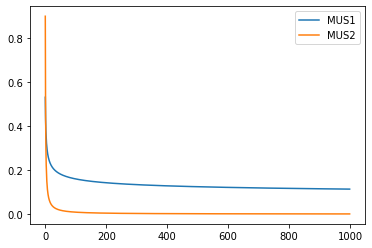

In [5]:
plt.plot(MUS1, label = "MUS1")
plt.plot(MUS2, label = "MUS2")
plt.legend()

In [7]:
lr_start = 0.9
lr_stop = 0.01
MUV1 = [max(lr_start/(1+j*0.005), lr_stop) for j in range(750)]
MUV2 = [max(lr_start/(1+j), lr_stop) for j in range(750)]

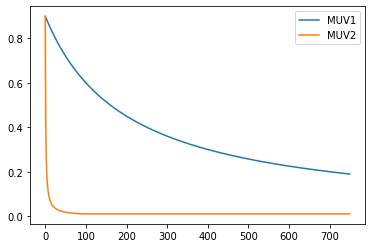

In [8]:
plt.plot(MUV1, label = "MUV1")
plt.plot(MUV2, label = "MUV2")
plt.legend()